# Real-World Data Demonstration

### Team Epsilon-Greedy Quants
#### Michael Lee, Nikat Patel, Jose Antonio Alatorre Sanchez

This notebook demonstrates what a user sees when the user runs the User Guide for Real-World Data Notebook

In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent

import datetime
import numpy as np
import pandas as pd
import os
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import quantstats as qs
qs.extend_pandas()

In [2]:
root = os.getcwd()
data_env = root+"/data_env/"

# Utility Functions

In [3]:
def _retrieve_asset_dict():
    # obtain close prices from parquet files of ETF price history
    root = os.getcwd()
    data_env = root+"/data_env_MTUM-EFAV/"
    files = [_ for _ in os.listdir(data_env) if "parquet" in _]
    assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in files}
    counter=0
    for key, value in assets_dict.items():
        if counter==0:
            main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")
        
    for key, value in assets_dict.items():
        tmp_df=value.reindex(main_index)
        tmp_df=tmp_df.fillna(method='ffill')
        assets_dict[key]=tmp_df['close']
    return assets_dict

def build_portfolio_df(asset_dict):
    portfolio_df = pd.DataFrame()
    
    for key, value in assets_dict.items():
        key = key.split(".")[0]
        tmp_df = pd.DataFrame(data=value)
        tmp_df.columns=[key]
        portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)
        
    portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce')
    return portfolio_df

In [4]:
def plot_backtest(linear_agent_train, env_test, test_input, model_run, model):
    ## Create plot of backtest returns
    if not "backtest" in locals():
        backtest=None
    backtest, tmp_weights =linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test, test_input=test_input)
    plt.figure(figsize=(8,4))
    plt.plot(backtest,color="blue")
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Date", fontsize = 10)
    plt.ylabel("Backtest", fontsize = 10)
    plt.title("Backtest on Test Data: "+ model,fontsize = 16)
    plt.savefig(root+'/temp_persisted_data/'+model_run+"_test_backtest_plot_"+model+'.png')
    tmp_weights.to_csv(root+'/temp_persisted_data/'+model_run+"_test_backtest_weights_"+model+'.csv')
    plt.show()
    return backtest

# Reviewing Real-World Data

In [5]:
# read a sample ETF

data_env_two_asset = root+ "/data_env_MTUM-EFAV/"

pd.read_parquet(data_env_two_asset+'EFAV.parquet').head()



,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,54.64474,54.72506,54.50195,54.69828,1035015
2017-01-04 05:00:00+00:00,54.96602,55.26945,54.95710,55.25160,1319625
2017-01-05 05:00:00+00:00,55.62643,55.96556,55.57289,55.90309,1834275
2017-01-06 05:00:00+00:00,55.72460,55.84062,55.68891,55.76030,1208694
2017-01-09 05:00:00+00:00,55.67998,55.79600,55.61751,55.76923,1024146


In [6]:
# create a portfolio
assets_dict = _retrieve_asset_dict()
portfolio_df = build_portfolio_df(assets_dict)

In [7]:
# create a train dataset and de-mean the time series

portfolio_df_train = portfolio_df[portfolio_df.index >= '2019-02-01']
portfolio_df_train = portfolio_df_train[portfolio_df_train.index <= '2020-02-01']
portfolio_df_train.sub(portfolio_df_train.mean())

portfolio_df_train.head()

,EFAV,MTUM
index,,
2019-02-01 05:00:00+00:00,65.81750,104.3037
2019-02-04 05:00:00+00:00,66.04416,104.4988
2019-02-05 05:00:00+00:00,66.40305,104.6647
2019-02-06 05:00:00+00:00,65.94972,104.7428
2019-02-07 05:00:00+00:00,65.49639,104.2744


In [8]:
# create a test dataset consisting of 6 months of data and de-mean the time series

portfolio_df_test = portfolio_df[portfolio_df.index >= '2020-04-16']
portfolio_df_test = portfolio_df_test[portfolio_df_test.index <= '2020-11-16']
portfolio_df_test.sub(portfolio_df_test.mean())

portfolio_df_test.head()

,EFAV,MTUM
index,,
2020-04-16 04:00:00+00:00,62.50506,116.0638
2020-04-17 04:00:00+00:00,63.45106,117.9653
2020-04-20 04:00:00+00:00,62.79575,116.7009
2020-04-21 04:00:00+00:00,61.94337,112.3304
2020-04-22 04:00:00+00:00,62.75141,115.3270


In [9]:
test_input_returns = portfolio_df_test.to_returns().dropna()
test_input_returns = test_input_returns.loc[(test_input_returns != 0).any(1)]


# Set Up Environment

In [10]:
# parameters related to the transformation of data, this parameters govern an step before the algorithm
out_reward_window=datetime.timedelta(days=7)

meta_parameters = {"in_bars_count": 1,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "risk_aversion":0.5,
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001}

print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)

detrend=True

# create an environment and build features based on Real-World Dataset located in the "data_env" folder 
env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="MTUM-EFAV", data_dir="data_env_MTUM-EFAV", detrend=detrend)

number_of_assets = env.number_of_assets

===Meta Parameters===
{'in_bars_count': 1, 'out_reward_window': datetime.timedelta(days=7), 'state_type': 'in_window_out_window', 'risk_aversion': 0, 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}


C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


#### Split Features and Forward Returns into Training and Test sets

In [11]:
features = pd.read_parquet("temp_persisted_data/only_features_MTUM-EFAV")
features

,EFAV.parquet_log_returns,MTUM.parquet_log_returns,EFAV.parquet_hw_trend,EFAV.parquet_hw_level,EFAV.parquet_hw_resid,EFAV.parquet_hw_demeaned_return,EFAV.parquet_hw_volatility,MTUM.parquet_hw_trend,MTUM.parquet_hw_level,MTUM.parquet_hw_resid,...,EFAV.parquet_hw_level_lag_1,EFAV.parquet_hw_resid_lag_1,EFAV.parquet_hw_demeaned_return_lag_1,EFAV.parquet_hw_volatility_lag_1,MTUM.parquet_hw_trend_lag_1,MTUM.parquet_hw_level_lag_1,MTUM.parquet_hw_resid_lag_1,MTUM.parquet_hw_demeaned_return_lag_1,MTUM.parquet_hw_volatility_lag_1,bias
index,,,,,,,,,,,,,,,,,,,,,
2018-01-04 05:00:00+00:00,0.005427,0.008348,0.802900,0.612209,0.642482,0.536420,0.001728,0.709507,0.352516,0.567256,...,0.605526,0.627724,0.523600,0.000320,0.703121,0.349160,0.550366,0.522023,0.005217,1
2018-01-05 05:00:00+00:00,0.002297,0.007997,0.809265,0.619380,0.643586,0.516670,0.000048,0.717868,0.356775,0.581251,...,0.612209,0.642482,0.536420,0.001728,0.709507,0.352516,0.567256,0.511769,0.002815,1
2018-01-08 05:00:00+00:00,-0.000270,0.002807,0.814258,0.626095,0.634436,0.501837,0.000647,0.725974,0.361235,0.579446,...,0.619380,0.643586,0.516670,0.000048,0.717868,0.356775,0.581251,0.507306,0.001904,1
2018-01-09 05:00:00+00:00,0.000135,0.003731,0.818196,0.632465,0.627403,0.504899,0.000416,0.734125,0.365989,0.579760,...,0.626095,0.634436,0.501837,0.000647,0.725974,0.361235,0.579446,0.482965,0.000058,1
2018-01-10 05:00:00+00:00,-0.002027,-0.001025,0.819920,0.637703,0.612628,0.493699,0.001739,0.740427,0.370387,0.566660,...,0.632465,0.627403,0.504899,0.000416,0.734125,0.365989,0.579760,0.486228,0.000001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-10 05:00:00+00:00,0.006381,-0.012501,0.766525,0.670561,0.765939,0.530001,0.001027,0.674679,0.968081,0.486934,...,0.655791,0.755620,0.553905,0.005585,0.679627,0.969448,0.537612,0.282942,0.156456,1
2020-11-11 05:00:00+00:00,0.008585,0.020153,0.793719,0.688410,0.782521,0.539059,0.002215,0.681233,0.970514,0.568444,...,0.670561,0.765939,0.530001,0.001027,0.674679,0.968081,0.486934,0.407662,0.028675,1
2020-11-12 05:00:00+00:00,-0.009575,-0.002721,0.812070,0.702455,0.723533,0.429743,0.026826,0.685510,0.972387,0.552313,...,0.688410,0.782521,0.539059,0.002215,0.681233,0.970514,0.568444,0.611331,0.058727,1


In [12]:
features = pd.read_parquet("temp_persisted_data/only_features_MTUM-EFAV")

features_train = features[features.index >= '2019-02-01']
features_train = features_train[features_train.index <= '2020-02-01']

features_test = features[features.index >= '2020-04-16']
features_test = features_test[features_test.index <= '2020-11-16']


features_train.head()

,EFAV.parquet_log_returns,MTUM.parquet_log_returns,EFAV.parquet_hw_trend,EFAV.parquet_hw_level,EFAV.parquet_hw_resid,EFAV.parquet_hw_demeaned_return,EFAV.parquet_hw_volatility,MTUM.parquet_hw_trend,MTUM.parquet_hw_level,MTUM.parquet_hw_resid,...,EFAV.parquet_hw_level_lag_1,EFAV.parquet_hw_resid_lag_1,EFAV.parquet_hw_demeaned_return_lag_1,EFAV.parquet_hw_volatility_lag_1,MTUM.parquet_hw_trend_lag_1,MTUM.parquet_hw_level_lag_1,MTUM.parquet_hw_resid_lag_1,MTUM.parquet_hw_demeaned_return_lag_1,MTUM.parquet_hw_volatility_lag_1,bias
index,,,,,,,,,,,,,,,,,,,,,
2019-02-01 05:00:00+00:00,-0.000143,0.001872,0.848868,0.531422,0.625671,0.500193,0.000891,0.779082,0.373830,0.582582,...,0.523293,0.635958,0.495703,0.001380,0.770533,0.367400,0.591606,0.504972,0.002037,1
2019-02-04 05:00:00+00:00,0.003438,0.001869,0.853100,0.540124,0.629363,0.520413,0.000110,0.786399,0.380131,0.573854,...,0.531422,0.625671,0.500193,0.000891,0.779082,0.373830,0.582582,0.471841,0.000729,1
2019-02-05 05:00:00+00:00,0.005419,0.001586,0.858896,0.550060,0.639793,0.530161,0.000858,0.792428,0.386239,0.564721,...,0.540124,0.629363,0.520413,0.000110,0.786399,0.380131,0.573854,0.472298,0.000726,1
2019-02-06 05:00:00+00:00,-0.006850,0.000746,0.859236,0.556967,0.603399,0.462427,0.010209,0.796913,0.392022,0.553788,...,0.550060,0.639793,0.530161,0.000858,0.792428,0.386239,0.564721,0.471672,0.000793,1
2019-02-07 05:00:00+00:00,-0.006898,-0.004482,0.854662,0.560843,0.570622,0.467659,0.008940,0.797958,0.396773,0.529405,...,0.556967,0.603399,0.462427,0.010209,0.796913,0.392022,0.553788,0.468900,0.001126,1


In [13]:
forward_return_dates = pd.read_parquet("temp_persisted_data/forward_return_dates_MTUM-EFAV")

forward_return_dates_train = forward_return_dates[forward_return_dates.index >= '2019-02-01']
forward_return_dates_train = forward_return_dates_train[forward_return_dates_train.index <= '2020-02-01']

forward_return_dates_test = forward_return_dates[forward_return_dates.index > '2020-04-16']
forward_return_dates_test = forward_return_dates_test[forward_return_dates_test.index <= '2020-11-16']

forward_return_dates_train.head()

,"forward_return_7_days,_0:00:00"
index,
2019-02-01 05:00:00+00:00,2019-02-08 05:00:00+00:00
2019-02-04 05:00:00+00:00,2019-02-11 05:00:00+00:00
2019-02-05 05:00:00+00:00,2019-02-12 05:00:00+00:00
2019-02-06 05:00:00+00:00,2019-02-13 05:00:00+00:00
2019-02-07 05:00:00+00:00,2019-02-14 05:00:00+00:00


In [14]:
forward_returns = pd.read_parquet("temp_persisted_data/only_forward_returns_MTUM-EFAV")

forward_returns_train = forward_returns[forward_returns.index >= '2019-02-01']
forward_returns_train = forward_returns_train[forward_returns_train.index <= '2020-02-01']
forward_returns_train.sub(forward_returns_train.mean())

forward_returns_test = forward_returns[forward_returns.index >= '2020-04-16']
forward_returns_test = forward_returns_test[forward_returns_test.index <= '2020-11-16']
forward_returns_test.sub(forward_returns_test.mean())

forward_returns_train.head()

,"EFAV.parquet_forward_return_7_days,_0:00:00","MTUM.parquet_forward_return_7_days,_0:00:00"
index,,
2019-02-01 05:00:00+00:00,-0.003731,0.003555
2019-02-04 05:00:00+00:00,-0.009438,0.001681
2019-02-05 05:00:00+00:00,-0.008534,0.010535
2019-02-06 05:00:00+00:00,-0.003151,0.010247
2019-02-07 05:00:00+00:00,0.006056,0.013568


# Run Policy-Gradient Method Algorithms on Real-World Data

In [15]:
max_iter = 4001
model_run = "MTUM-EFAV_lambda_0.5"
sample_observations = 32
plot_interval = 500

### REINFORCE

  0%|                                                                                           | 0/36 [00:00<?, ?it/s]C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\pypfopt\risk_models.py:69: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  "The covariance matrix is non positive semidefinite. Amending eigenvalues."
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\pypfopt\risk_models.py:88: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn("Could not fix matrix. Please try a different risk model.")
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\pypfopt

C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
 72%|███████████████████████████████████████████████████████████▏                      | 26/36 [00:00<00:00, 80.74it/s]C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\numpy\lib\function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
 12%|█████████▊                                                                     | 500/4001 [01:07<07:39,  7.61it/s]

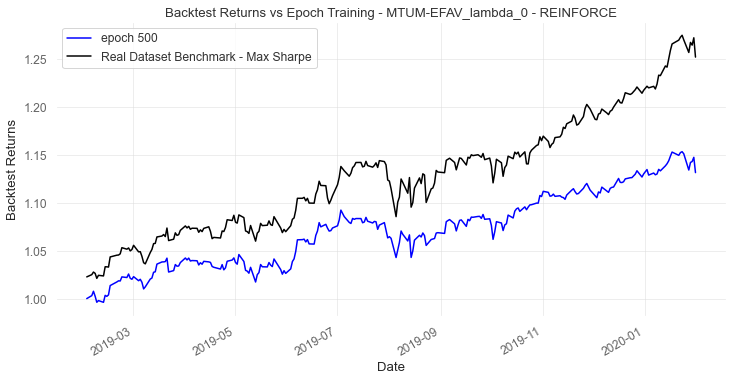

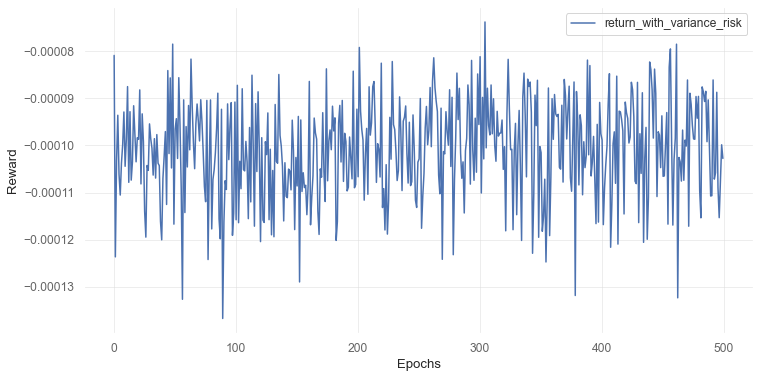

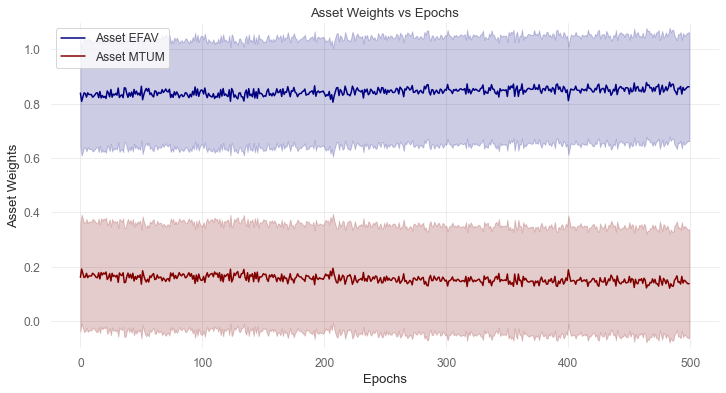

<Figure size 864x432 with 0 Axes>

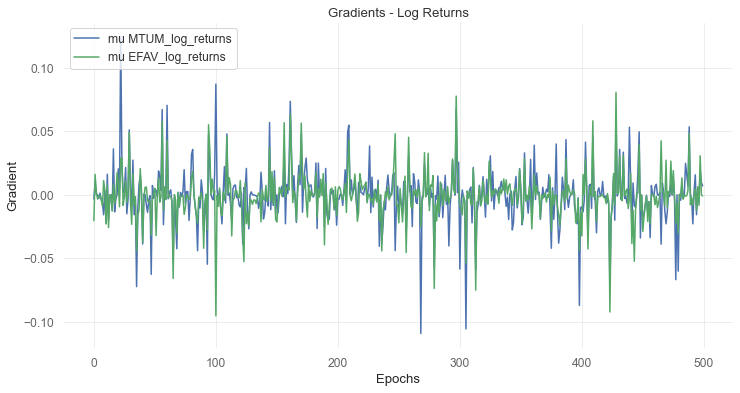

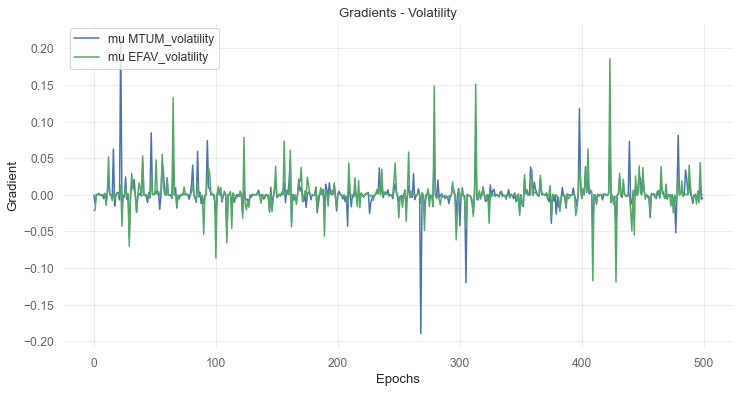

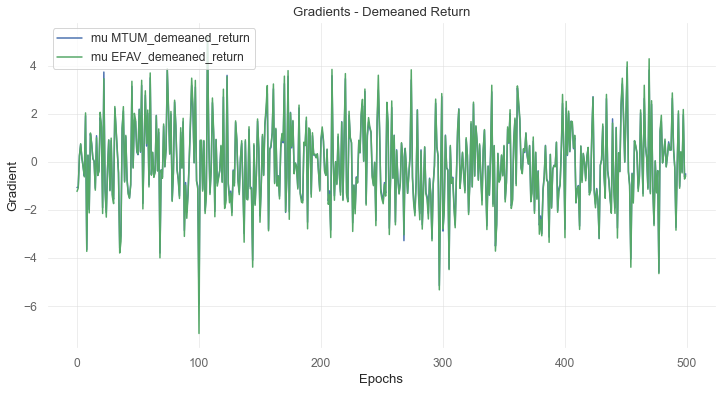

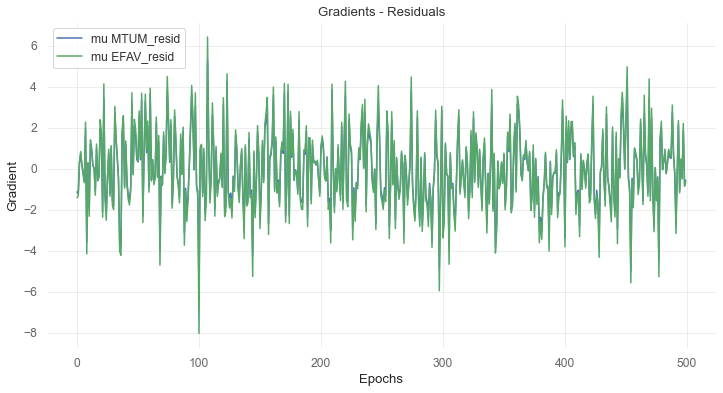

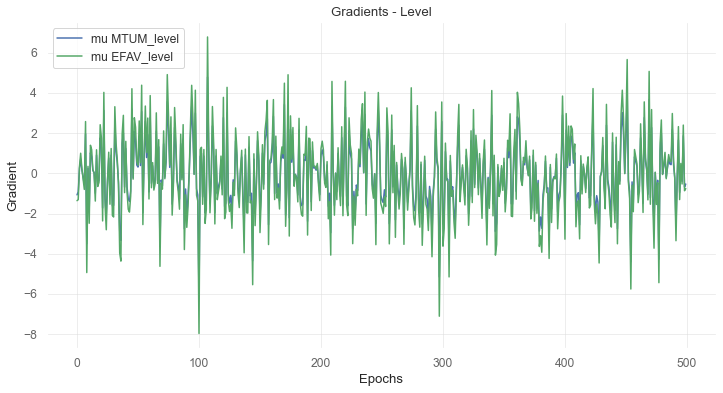

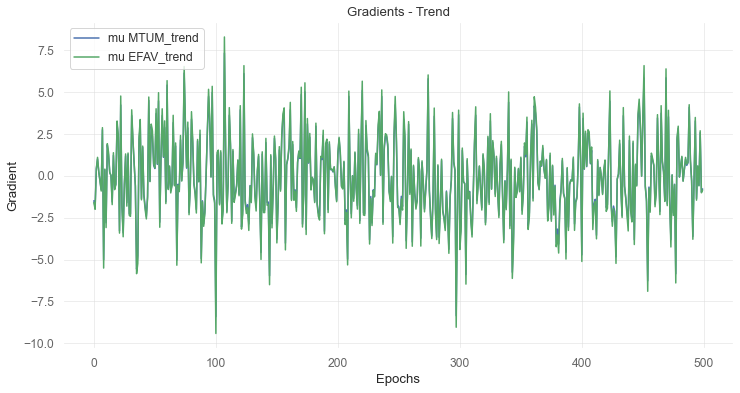

 14%|███████████                                                                    | 558/4001 [01:18<07:12,  7.96it/s]

In [ ]:
# create environment and run REINFORCE

env_reinforce_train=DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce = LinearAgent(environment=env_reinforce_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce._load_benchmark(portfolio_df)
linear_agent_reinforce.REINFORCE_fit(max_iterations=max_iter, add_baseline=False, plot_every = plot_interval, train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_reinforce = plot_backtest(linear_agent_reinforce, env_reinforce_test, portfolio_df_test, model_run, model="REINFORCE")
backtest_reinforce.to_csv('temp_persisted_data/'+model_run+'_backtest_reinforce.csv')

In [ ]:
(test_input_returns+1).cumprod().plot()

In [ ]:
(test_input_returns.sum(axis=1)+1).cumprod().plot()

### REINFORCE with Baseline

In [ ]:
# create environment and run REINFORCE with baseline
env_reinforce_baseline_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_baseline_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce_baseline = LinearAgent(environment=env_reinforce_baseline_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce_baseline._load_benchmark(portfolio_df)
linear_agent_reinforce_baseline.REINFORCE_fit(max_iterations=max_iter, add_baseline=True, plot_every = plot_interval, train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline, env_reinforce_baseline_test, portfolio_df_test, model_run, model="REINFORCE with Baseline")
backtest_reinforce_baseline.to_csv('temp_persisted_data/'+model_run+'_backtest_reinforce_baseline.csv')

### Actor-Critic

In [ ]:
# create environment and run Actor-Critic 

env_actor_critic_no_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_no_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_no_trace = LinearAgent(environment=env_actor_critic_no_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_no_trace._load_benchmark(portfolio_df)
linear_agent_actor_critic_no_trace.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter, plot_every = plot_interval,train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest
backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace, env_actor_critic_no_trace_test,  portfolio_df_test, model_run, model="Actor-Critic without Eligibility Traces")
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/'+model_run+'_backtest_actor_critic_no_trace.csv')

### Actor-Critic with Eligibility Traces

In [ ]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_trace = LinearAgent(environment=env_actor_critic_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_trace._load_benchmark(portfolio_df)
linear_agent_actor_critic_trace.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter, plot_every = plot_interval,train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace, env_actor_critic_trace_test,  portfolio_df_test, model_run, model="Actor-Critic with Eligibility Traces")
backtest_actor_critic_trace.to_csv('temp_persisted_data/'+model_run+'_backtest_actor_critic_trace.csv')